In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  9 20:47:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8    18W / 100W |     54MiB /  6144MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2024-06-09 20:47:07.244932: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 20:47:07.246111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 20:47:07.272076: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 20:47:07.272377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 20:47:07.956613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1
BATCH_SIZE=16

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=50000   
LEARNING_RATE=0.001

# GYM Acrobot

In [6]:
# Definimos el entorno
env= gym.make('Acrobot-v1')

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

3
6


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a] reales o sintéticas, de longitud ob_space.shape[0] + ac_space.n.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n)),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 10)          100       
                                                                 
 layer2 (Dense)              (None, None, 10)          110       
                                                                 
 layer3 (Dense)              (None, None, 10)          110       
                                                                 
 prob (Dense)                (None, None, 1)           11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-06-09 20:47:10.497600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-09 20:47:10.497625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-09 20:47:10.497628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-09 20:47:10.497723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-06-09 20:47:10.497736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-06-09 20:47:10.497739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5


## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [9]:
#########################################################################################
# Clase DISCRIMINADOR
########################################################################################
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) 


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [10]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 6, s=[s1,s2,s3,s4,s5,s6]
# Output: acciones, listas de tamaño 3, a=[a1,a2,a3]
generator_net_Act=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation=tf.tanh,name='layer1'),
            layers.Dense(units=6, activation=tf.tanh, name='layer2'),
            layers.Dense(units=4, activation=tf.tanh, name='layer3'),
            layers.Dense(units=3, activation=tf.nn.softmax, name='layer4')

        ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           42        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 4)           28        
                                                                 
 layer4 (Dense)              (None, None, 3)           15        
                                                                 
Total params: 127 (508.00 Byte)
Trainable params: 127 (508.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 6, s=[s1,s2,s3,s4.s5,s6]
# Output: v_pred, listas de tamaño 1, v_pred
generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation=tf.tanh,name='layer1'),
            layers.Dense(units=6, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           42        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 1)           7         
                                                                 
Total params: 91 (364.00 Byte)
Trainable params: 91 (364.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [12]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################
def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [13]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
  def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



  # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
  # La elección de la acción puede ser estocástica o determinística
  def act(self, stochastic=True):
      if stochastic:
          return self.act_stochastic, self.v_preds
      else:
          return self.act_deterministic, self.v_preds

  def get_action_prob(self):
      return self.act_probs

  def get_v_preds(self):
      return self.v_preds

  def get_obs(self):
      return self.obs

  def get_model(self):
      return self.model

  def get_trainable_variables(self):
      return self.model.get_parameters()

  # Generar [s,a] falsos
  def generate_fakes(self):

      ob_space = env.observation_space
      reward = 0
      success_num = 0

      # Por cada episodio
      for iteration in range(EPISODES):
          # Inicializo todas las variables
          observations = []
          actions = []
          rewards = []
          run_policy_steps = 0

          truncated=False
          terminated=False


          #La primera acción de cada episodio se crea con la red neuronal

          obs,_=env.reset()

          Old_Policy = Policy_net('old_policy', env, obs=obs)

          act, v_pred = Old_Policy.act(stochastic=True)

          #Convertir de tensor a array
          if type(act)=='Tensor':
              # Crear una sesión de TensorFlow
              sess = tf.compat.v1.Session()

              # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
              act = sess.run(act)

              # Cerrar la sesión
              sess.close()

          if isinstance(act, tf.Tensor):
              act=act.numpy()

          elif isinstance(act, np.ndarray):
              act=act


          action=int(act)

          next_obs,reward,terminated,truncated, info=env.step(action)

          # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
          observations.append(next_obs)  # S_0

          Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

          # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
          while terminated!= True and truncated!= True:
              # --Aumentar el numero de steps
              run_policy_steps += 1

              # --Política para ver la acción asociada al estado
              # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
              action, states_oc = Policy.get_model().predict(next_obs)

              action=int(action)

              # --Muevo al Agente al siguiente estado
              next_obs,reward,terminated,truncated,info=env.step(action)
                
              # --Actualización de variables
              actions.append(action) # A_i-1
              rewards.append(reward) # R_i-1
              

              # --Si llegamos a un estado final, el juego ha finalizado!!!
              # --Se configura el tablero de nuevo
              if terminated== True or truncated==True:
                  obs = env.reset()
                  reward = -1
                  break
              else:
                  observations.append(next_obs) # O_i 
                  self.obs = next_obs

          # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
          if sum(rewards) >= 195:
              success_num += 1
              if success_num >= 100:
                  break
          else:
              success_num = 0


      observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
      actions = np.array(actions).astype(dtype=np.int32)


      return observations, actions, rewards, Old_Policy, Policy

In [14]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:
  def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

  def loss_fn_G(self):
      return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

  def get_pi_trainable(self):
      return self.pi

  def get_optimizer(self):
      return self.optimizer

  def get_OldPolicy(self):
      return self.Old_Policy

  def get_Policy(self):
      return self.Policy

  def get_gaes(self, rewards, v_preds, v_preds_next):
      deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
      # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
      gaes = copy.deepcopy(deltas)
      for t in reversed(range(len(gaes) - 1)):  # # es T-1, donde T es time step con el que se ejecuta la política
          gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
      return gaes

# GAIL

In [15]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('Acrobot-v1')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))
                print(reward)
                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):


        # 1) Generamos secuencias falsas [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, (generate_observations.shape[0], ac_space.n))
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento  
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices]

        ## 3) Obtenemos las secuencias reales [s,a] de los datos de entrenamiento y las combinamos
        combined_images = tf.concat([X_train, dataset_gen], axis=0) 


        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )


        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

          
        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}




# Experimentación de GAIL con Acrobot

## Experimento 1


### Construcción de base de datos con 1 trayectoria

In [16]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [17]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

75


In [18]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [19]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 [ 9.9830514e-01 -5.8196500e-02  9.7622800e-01  2.1674618e-01
  -1.7613347e-01  6.5750950e-01]
 [ 9.9567330e-01 -9.2922850e-02  9.3925875e-01  3.4320990e-01
  -1.6115366e-01  6.3362290e-01]
 [ 9.9297390e-01 -1.1833351e-01  8.9533660e-01  4.4539005e-01
  -8.6712144e-02  4.5844048e-01]
 [ 9.9212956e-01 -1.2521543e-01  8.6422575e-01  5.0310420e-01
   1.9709177e-02  1.8744679e-01]
 [ 9.9631774e-01 -8.5737730e-02  8.9179600e-01  4.5243770e-01
   3.6868936e-01 -7.5178180e-01]
 [ 9.9987860e-01  1.5582174e-02  9.7184490e-01  2.3562142e-01
   6.2113965e-01 -1.5166148e+00]
 [ 9.8892045e-01  1.4844657e-01  9.9404310e-01 -1.0898746e-01
   6.7270136e-01 -1.8689271e+00]
 [ 9.6453670e-01  2.6394865e-0

### Separación de Train y Test

In [20]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02  0.0000000e+00  0.0000000e+00
   1.0000000e+00]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01  0.0000000e+00  0.0000000e+00
   1.0000000e+00]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01  0.0000000e+00  0.0000000e+00
   1.0000000e+00]
 [ 9.9830514e-01 -5.8196500e-02  9.7622800e-01  2.1674618e-01
  -1.7613347e-01  6.5750950e-01  0.0000000e+00  0.0000000e+00
   1.0000000e+00]
 [ 9.9567330e-01 -9.2922850e-02  9.3925875e-01  3.4320990e-01
  -1.6115366e-01  6.3362290e-01  0.0000000e+00  0.0000000e+00
   1.0000000e+00]
 [ 9.9297390e-01 -1.1833351e-01  8.9533660e-01  4.4539005e-01
  -8.6712144e-02  4.5844048e-01  0.0000000e+00  0.0000000e+00
   1.0000000e+00]
 [ 9.9212956e-01 -1.2521543e-01  8.6422575e-01  5.0310420e-01
   1.9709177e-02  1.8744679e-01  1.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 9.9

In [21]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

/home/usuario/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [24]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [25]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

/home/usuario/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(





d_loss= 2.2518942

g_loss= 1.1303203
1/4 [======>.......................] - ETA: 27:40 - d_loss: 2.2519 - g_loss: 1.1303


d_loss= 2.2409227

g_loss= 3.5461822
2/4 [==============>...............] - ETA: 18:25 - d_loss: 2.2464 - g_loss: 2.3383


d_loss= 2.4527268

g_loss= 1.0406334
3/4 [=====================>........] - ETA: 9:11 - d_loss: 2.3152 - g_loss: 1.9057 


d_loss= 2.2178757

g_loss= 0.97726667
4/4 [==============================] - 2213s 553s/step - d_loss: 2.2909 - g_loss: 1.6736


### Evaluación de GAIL

In [26]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.3897 - accuracy: 0.0000e+00
>Loss real: 
0.37873294949531555
>Loss fake: 
0.3896591067314148


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -78.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -70.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


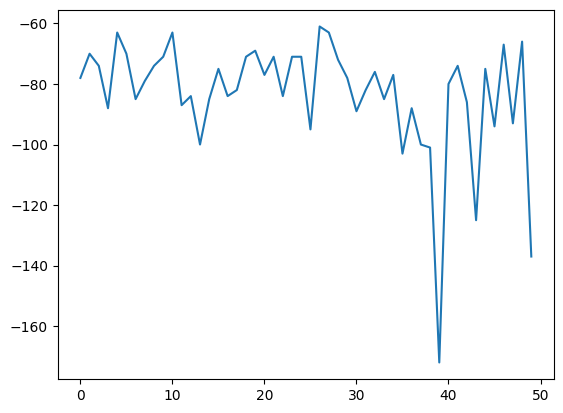


Recompensa de Media: -83.3 



In [27]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2


### Construcción de base de datos con 2 trayectoria

In [28]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [29]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

222


In [30]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [31]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [-5.6692475e-01 -8.2376957e-01 -9.9830280e-01 -5.8236170e-02
   8.3579020e+00 -2.3817885e+00]
 [ 9.2723423e-01 -3.7448192e-01 -7.9130400e-01  6.1142296e-01
   9.3767395e+00 -5.5276450e+00]
 [ 1.3842252e-01  9.9037325e-01  7.0662427e-01  7.0758900e-01
   8.7495870e+00 -1.1370151e+01]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

### Separación de Train y Test

In [32]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [-0.56692475 -0.82376957 -0.9983028  ...  1.          0.
   0.        ]
 [ 0.92723423 -0.37448192 -0.791304   ...  1.          0.
   0.        ]
 [ 0.13842252  0.99037325  0.70662427 ...  1.          0.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 177
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 45


In [33]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [34]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [35]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [36]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [37]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 2.2695217

g_loss= 1.0544847
 1/12 [=>............................] - ETA: 1:41:27 - d_loss: 2.2695 - g_loss: 1.0545


d_loss= 2.2806761

g_loss= 1.6386554
 2/12 [====>.........................] - ETA: 1:32:57 - d_loss: 2.2751 - g_loss: 1.3466


d_loss= 2.2953641

g_loss= 1.5786821
 3/12 [======>.......................] - ETA: 1:23:38 - d_loss: 2.2819 - g_loss: 1.4239


d_loss= 2.2971346

g_loss= 1.2791259
 4/12 [=========>....................] - ETA: 1:13:51 - d_loss: 2.2857 - g_loss: 1.3877


d_loss= 2.4386837

g_loss= 4.4174113
 5/12 [===========>..................] - ETA: 1:04:45 - d_loss: 2.3163 - g_loss: 1.9937


d_loss= 2.231522

g_loss= 0.7065288
 6/12 [==============>...............] - ETA: 55:25 - d_loss: 2.3022 - g_loss: 1.7791  


d_loss= 2.1804972

g_loss= 1.7990268
 7/12 [================>.............] - ETA: 46:17 - d_loss: 2.2848 - g_loss: 1.7820


d_loss= 2.2207637

g_loss= 1.2358154
 8/12 [===================>..........] - ETA: 36:56 - d_loss: 2.2768 - g_l

### Evaluación de GAIL

In [38]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)

1/1 [==============================] - 0s 18ms/step - loss: 0.2031 - accuracy: 0.0000e+00
>Loss real: 
0.3431917428970337
>Loss fake: 
0.20308487117290497


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -85.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -77.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


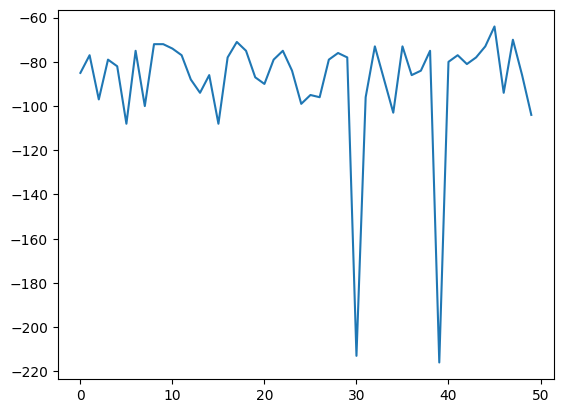


Recompensa de Media: -89.0 



In [39]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3


### Construcción de base de datos con 3 trayectoria

In [40]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [41]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

303


In [42]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [43]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.9997995  -0.02002486  0.9999777   0.00667336  0.09675691 -0.08898636]
 [ 0.99992436 -0.01229871  0.99976075  0.02187367 -0.02038282  0.2391906 ]
 [ 0.99962884 -0.02724211  0.9951261   0.09861034 -0.12337531  0.5136798 ]
 ...
 [ 0.9857675  -0.16811456 -0.6881886  -0.7255319   4.877121   -5.7286177 ]
 [ 0.6870794   0.7265823  -0.9737162   0.22776459  4.6909723  -4.8336315 ]
 [-0.06043336  0.9981722  -0.39808586  0.91734815  3.4433959  -4.49635   ]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2

### Separación de Train y Test

In [44]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [ 0.9857675  -0.16811456 -0.6881886  ...  1.          0.
   0.        ]
 [ 0.6870794   0.7265823  -0.9737162  ...  1.          0.
   0.        ]
 [-0.06043336  0.9981722  -0.39808586 ...  1.          0.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 242
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 61


In [45]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [46]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [47]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [48]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [49]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 2.182566

g_loss= 1.1911863
 1/16 [>.............................] - ETA: 2:16:03 - d_loss: 2.1826 - g_loss: 1.1912


d_loss= 2.1327248

g_loss= 1.1682745
 2/16 [==>...........................] - ETA: 2:05:17 - d_loss: 2.1576 - g_loss: 1.1797


d_loss= 2.2107308

g_loss= 2.4448516
 3/16 [====>.........................] - ETA: 1:57:28 - d_loss: 2.1753 - g_loss: 1.6014


d_loss= 2.1755617

g_loss= 1.1192673
 4/16 [======>.......................] - ETA: 1:48:42 - d_loss: 2.1754 - g_loss: 1.4809


d_loss= 2.1955094

g_loss= 1.821415
 5/16 [========>.....................] - ETA: 1:39:42 - d_loss: 2.1794 - g_loss: 1.5490


d_loss= 2.226393

g_loss= 4.3426356
 6/16 [==========>...................] - ETA: 1:30:37 - d_loss: 2.1872 - g_loss: 2.0146


d_loss= 2.124516

g_loss= 0.9183674
 7/16 [============>.................] - ETA: 1:21:17 - d_loss: 2.1783 - g_loss: 1.8580


d_loss= 2.0500839

g_loss= 7.322377
 8/16 [==============>...............] - ETA: 1:12:14 - d_loss: 2.1623 - g_l

### Evaluación de GAIL

In [50]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.1985 - accuracy: 0.0000e+00
>Loss real: 
0.23201756179332733
>Loss fake: 
0.19850236177444458


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -91.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -90.0
-1.0
-1.0
-1.0
-1.0
-1.0


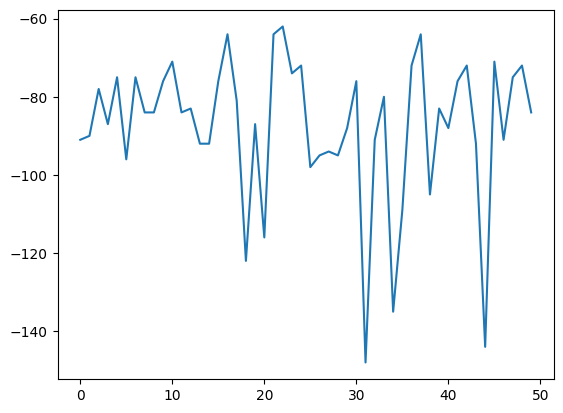


Recompensa de Media: -87.48 



In [51]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4


### Construcción de base de datos con 4 trayectoria

In [52]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [53]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

377


In [54]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [55]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.9997995  -0.02002486  0.9999777   0.00667336  0.09675691 -0.08898636]
 [ 0.99992436 -0.01229871  0.99976075  0.02187367 -0.02038282  0.2391906 ]
 [ 0.99962884 -0.02724211  0.9951261   0.09861034 -0.12337531  0.5136798 ]
 ...
 [-0.26331887 -0.96470886  0.5954457   0.80339557 -2.2415764  -0.34711412]
 [-0.53225034 -0.846587    0.7620752   0.64748853 -0.75079244 -1.8235965 ]
 [-0.5498423  -0.8352685   0.9741778   0.22578229  0.5181285  -2.9309454 ]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2

### Separación de Train y Test

In [56]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [-0.26331887 -0.96470886  0.5954457  ...  1.          0.
   0.        ]
 [-0.53225034 -0.846587    0.7620752  ...  1.          0.
   0.        ]
 [-0.5498423  -0.8352685   0.9741778  ...  1.          0.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 301
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 76


In [57]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [58]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [59]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [60]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [61]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 2.0657148

g_loss= 1.1559565
 1/19 [>.............................] - ETA: 2:41:55 - d_loss: 2.0657 - g_loss: 1.1560


d_loss= 2.0820532

g_loss= 8.746441
 2/19 [==>...........................] - ETA: 2:28:41 - d_loss: 2.0739 - g_loss: 4.9512


d_loss= 2.0652056

g_loss= 3.8968434
 3/19 [===>..........................] - ETA: 2:20:22 - d_loss: 2.0710 - g_loss: 4.5997


d_loss= 2.207173

g_loss= 1.1898577
 4/19 [=====>........................] - ETA: 2:13:15 - d_loss: 2.1050 - g_loss: 3.7473


d_loss= 2.051834

g_loss= 0.82782394
 5/19 [======>.......................] - ETA: 2:05:09 - d_loss: 2.0944 - g_loss: 3.1634


d_loss= 2.1073265

g_loss= 2.1039195
 6/19 [========>.....................] - ETA: 1:56:02 - d_loss: 2.0966 - g_loss: 2.9868


d_loss= 2.2175667

g_loss= 0.69452626
 7/19 [==========>...................] - ETA: 1:46:44 - d_loss: 2.1138 - g_loss: 2.6593


d_loss= 2.164901

g_loss= 1.1646003
 8/19 [===========>..................] - ETA: 1:37:37 - d_loss: 2.1202 - 

### Evaluación de GAIL

In [62]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)

1/1 [==============================] - 0s 18ms/step - loss: 0.0705 - accuracy: 0.0000e+00
>Loss real: 
0.15448668599128723
>Loss fake: 
0.07053407281637192


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -108.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -75.0
-1.0
-1.0
-1.0

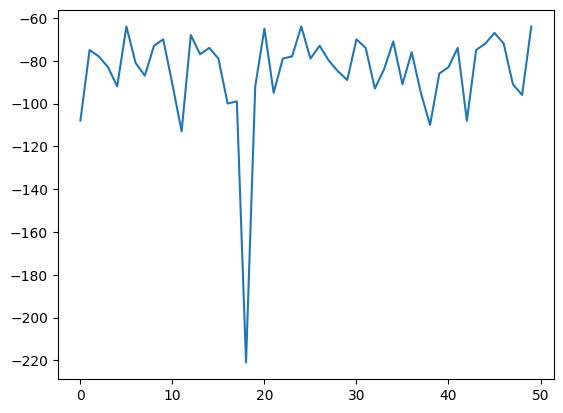


Recompensa de Media: -85.28 



In [63]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5


### Construcción de base de datos con 1 trayectoria

In [64]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [65]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

460


In [66]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [67]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.9997995  -0.02002486  0.9999777   0.00667336  0.09675691 -0.08898636]
 [ 0.99992436 -0.01229871  0.99976075  0.02187367 -0.02038282  0.2391906 ]
 [ 0.99962884 -0.02724211  0.9951261   0.09861034 -0.12337531  0.5136798 ]
 ...
 [-0.5521396   0.8337517  -0.02509269 -0.9996851   1.8698325   1.4604249 ]
 [-0.71873397  0.6952852   0.39560738 -0.9184197   0.3529692   2.7451994 ]
 [-0.6774969   0.7355256   0.8687861  -0.49518758 -0.90125334  3.718862  ]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2

### Separación de Train y Test

In [68]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [-0.5521396   0.8337517  -0.02509269 ...  0.          0.
   1.        ]
 [-0.71873397  0.6952852   0.39560738 ...  0.          0.
   1.        ]
 [-0.6774969   0.7355256   0.8687861  ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 368
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 92


In [69]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [70]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [71]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [72]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [73]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 2.0759275

g_loss= 2.9328663
 1/23 [>.............................] - ETA: 3:16:57 - d_loss: 2.0759 - g_loss: 2.9329


d_loss= 1.8077921

g_loss= 3.765517
 2/23 [=>............................] - ETA: 3:11:08 - d_loss: 1.9419 - g_loss: 3.3492


d_loss= 2.104953

g_loss= 1.1711317
 3/23 [==>...........................] - ETA: 3:01:42 - d_loss: 1.9962 - g_loss: 2.6232


d_loss= 1.9522724

g_loss= 1.6075618
 4/23 [====>.........................] - ETA: 2:52:37 - d_loss: 1.9852 - g_loss: 2.3693


d_loss= 1.9819567

g_loss= 1.7387638
 5/23 [=====>........................] - ETA: 2:43:04 - d_loss: 1.9846 - g_loss: 2.2432


d_loss= 2.0743847

g_loss= 2.4321306
 6/23 [======>.......................] - ETA: 2:33:47 - d_loss: 1.9995 - g_loss: 2.2747


d_loss= 1.9385953

g_loss= 1.0529245
 7/23 [========>.....................] - ETA: 2:24:13 - d_loss: 1.9908 - g_loss: 2.1001


d_loss= 1.9983978

g_loss= 3.209939
 8/23 [=========>....................] - ETA: 2:15:03 - d_loss: 1.9918 - g

### Evaluación de GAIL

In [74]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.1427 - accuracy: 0.0000e+00
>Loss real: 
0.06974410265684128
>Loss fake: 
0.14273402094841003


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -86.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -73.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


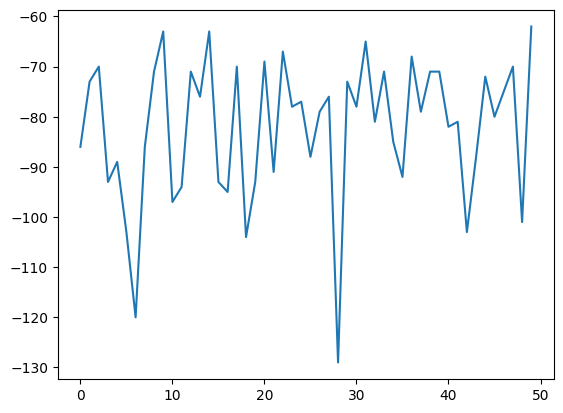


Recompensa de Media: -82.24 



In [75]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6


In [76]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [77]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

547


In [78]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [79]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.0978660e-01  4.1507630e-01  9.9909365e-01  4.2565778e-02
   5.0572224e+00 -1.2297401e+01]
 [ 3.3433688e-01  9.4245360e-01 -5.0802960e-01 -8.6133960e-01
   2.5722346e+00 -8.5953600e+00]
 [ 1.4239504e-02  9.9989860e-01 -8.8892007e-01  4.5806238e-01
   1.0503234e+00 -6.9006367e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

### Separación de Train y Test

In [80]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [ 0.9097866   0.4150763   0.99909365 ...  1.          0.
   0.        ]
 [ 0.33433688  0.9424536  -0.5080296  ...  1.          0.
   0.        ]
 [ 0.0142395   0.9998986  -0.88892007 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [81]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [82]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [83]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [84]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [85]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 2.003979

g_loss= 4.6730795
 1/28 [>.............................] - ETA: 3:55:07 - d_loss: 2.0040 - g_loss: 4.6731


d_loss= 2.0033066

g_loss= 3.5584874
 2/28 [=>............................] - ETA: 3:40:37 - d_loss: 2.0036 - g_loss: 4.1158


d_loss= 1.9114786

g_loss= 4.219261
 3/28 [==>...........................] - ETA: 3:33:11 - d_loss: 1.9729 - g_loss: 4.1503


d_loss= 2.1522574

g_loss= 5.59491
 4/28 [===>..........................] - ETA: 3:27:44 - d_loss: 2.0178 - g_loss: 4.5114


d_loss= 2.0250032

g_loss= 0.9674739
 5/28 [====>.........................] - ETA: 3:18:45 - d_loss: 2.0192 - g_loss: 3.8026


d_loss= 1.9849737

g_loss= 4.212826
 6/28 [=====>........................] - ETA: 3:14:37 - d_loss: 2.0135 - g_loss: 3.8710


d_loss= 1.9503047

g_loss= 1.2812153
 7/28 [======>.......................] - ETA: 3:08:29 - d_loss: 2.0045 - g_loss: 3.5010


d_loss= 1.9901296

g_loss= 0.7080766
 8/28 [=======>......................] - ETA: 3:01:10 - d_loss: 2.0027 - g_l

### Evaluación de GAIL

In [86]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.0259 - accuracy: 0.0000e+00
>Loss real: 
0.028906913474202156
>Loss fake: 
0.02594836615025997


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -106.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -77.0
-1.0
-1.0
-1.0

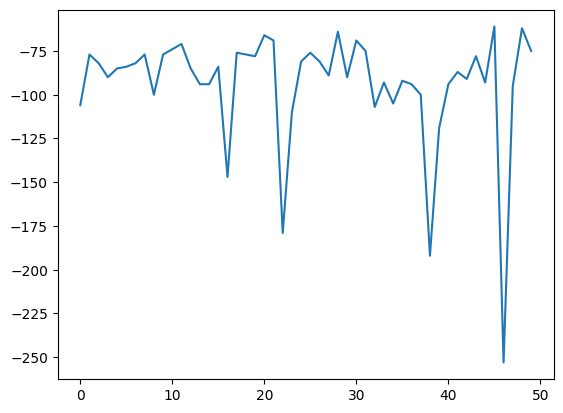


Recompensa de Media: -93.6 



In [87]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7


### Construcción de base de datos con 7 trayectoria

In [88]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [89]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

634


In [90]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [91]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.9997995  -0.02002486  0.9999777   0.00667336  0.09675691 -0.08898636]
 [ 0.99992436 -0.01229871  0.99976075  0.02187367 -0.02038282  0.2391906 ]
 [ 0.99962884 -0.02724211  0.9951261   0.09861034 -0.12337531  0.5136798 ]
 ...
 [ 0.9904837  -0.13763     0.1491538   0.988814    4.2935095   0.98311174]
 [ 0.69572634  0.71830696  0.29672527  0.9549629   4.781197   -2.1823397 ]
 [-0.11673388  0.9931632   0.7711701   0.6366292   3.9840815  -3.291864  ]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2

### Separación de Train y Test

In [92]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [ 0.9904837  -0.13763     0.1491538  ...  1.          0.
   0.        ]
 [ 0.69572634  0.71830696  0.29672527 ...  1.          0.
   0.        ]
 [-0.11673388  0.9931632   0.7711701  ...  1.          0.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 507
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 127


In [93]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [94]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [95]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [96]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [97]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 1.8437461

g_loss= 1.8187864
 1/32 [..............................] - ETA: 4:42:48 - d_loss: 1.8437 - g_loss: 1.8188


d_loss= 1.8702093

g_loss= 1.529155
 2/32 [>.............................] - ETA: 4:38:04 - d_loss: 1.8570 - g_loss: 1.6740


d_loss= 2.0312626

g_loss= 1.4134219
 3/32 [=>............................] - ETA: 4:34:01 - d_loss: 1.9151 - g_loss: 1.5871


d_loss= 1.9152862

g_loss= 4.4419675
 4/32 [==>...........................] - ETA: 4:23:19 - d_loss: 1.9151 - g_loss: 2.3008


d_loss= 2.1343613

g_loss= 0.889913
 5/32 [===>..........................] - ETA: 4:09:11 - d_loss: 1.9590 - g_loss: 2.0186


d_loss= 1.872995

g_loss= 2.243364
 6/32 [====>.........................] - ETA: 3:57:11 - d_loss: 1.9446 - g_loss: 2.0561


d_loss= 1.9914677

g_loss= 1.8846706
 7/32 [=====>........................] - ETA: 3:46:40 - d_loss: 1.9513 - g_loss: 2.0316


d_loss= 1.8740915

g_loss= 3.2467935
 8/32 [======>.......................] - ETA: 3:36:30 - d_loss: 1.9417 - g_

### Evaluación de GAIL

In [98]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.0099 - accuracy: 0.0000e+00
>Loss real: 
0.007292110472917557
>Loss fake: 
0.009870794601738453


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -77.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -83.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


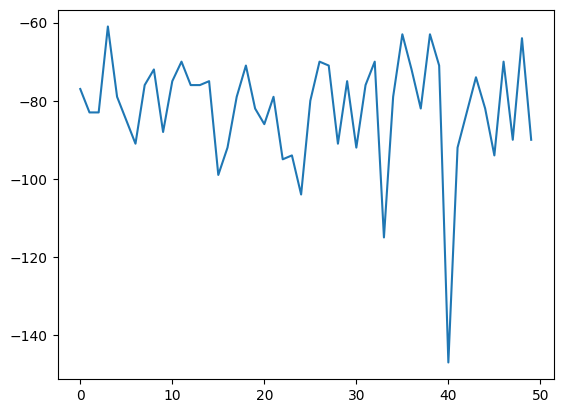


Recompensa de Media: -82.08 



In [99]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8


### Construcción de base de datos con 8 trayectoria

In [100]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [101]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

710


In [102]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [103]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.9997995  -0.02002486  0.9999777   0.00667336  0.09675691 -0.08898636]
 [ 0.99992436 -0.01229871  0.99976075  0.02187367 -0.02038282  0.2391906 ]
 [ 0.99962884 -0.02724211  0.9951261   0.09861034 -0.12337531  0.5136798 ]
 ...
 [ 0.45707658  0.88942736 -0.8719547  -0.4895866  -4.0831685  -0.8888238 ]
 [ 0.9873944   0.15827909 -0.8370126  -0.5471836  -5.0736675   1.4564772 ]
 [ 0.6714395  -0.74105936 -0.50523686 -0.8629807  -4.648609    2.9974432 ]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2

### Separación de Train y Test

In [104]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [ 0.45707658  0.88942736 -0.8719547  ...  0.          0.
   1.        ]
 [ 0.9873944   0.15827909 -0.8370126  ...  0.          0.
   1.        ]
 [ 0.6714395  -0.74105936 -0.50523686 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 568
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 142


In [105]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [106]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [107]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [108]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 2.029172

g_loss= 1.5457757
 1/36 [..............................] - ETA: 5:14:07 - d_loss: 2.0292 - g_loss: 1.5458


d_loss= 1.848647

g_loss= 1.1647683
 2/36 [>.............................] - ETA: 5:05:25 - d_loss: 1.9389 - g_loss: 1.3553


d_loss= 2.003385

g_loss= 1.9449853
 3/36 [=>............................] - ETA: 4:53:51 - d_loss: 1.9604 - g_loss: 1.5518


d_loss= 1.8794781

g_loss= 2.5253031
 4/36 [==>...........................] - ETA: 4:43:33 - d_loss: 1.9402 - g_loss: 1.7952


d_loss= 1.9181042

g_loss= 3.0155618
 5/36 [===>..........................] - ETA: 4:36:22 - d_loss: 1.9358 - g_loss: 2.0393


d_loss= 1.9615573

g_loss= 5.466392
 6/36 [====>.........................] - ETA: 4:29:59 - d_loss: 1.9401 - g_loss: 2.6105


d_loss= 1.9795

g_loss= 0.98541915
 7/36 [====>.........................] - ETA: 4:22:21 - d_loss: 1.9457 - g_loss: 2.3783


d_loss= 1.9199533

g_loss= 1.3260463
 8/36 [=====>........................] - ETA: 4:13:59 - d_loss: 1.9425 - g_lo

### Evaluación de GAIL

In [109]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 0.0000e+00
>Loss real: 
0.0011468162992969155
>Loss fake: 
0.001350867678411305


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -91.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -92.0
-1.0
-1.0
-1.0


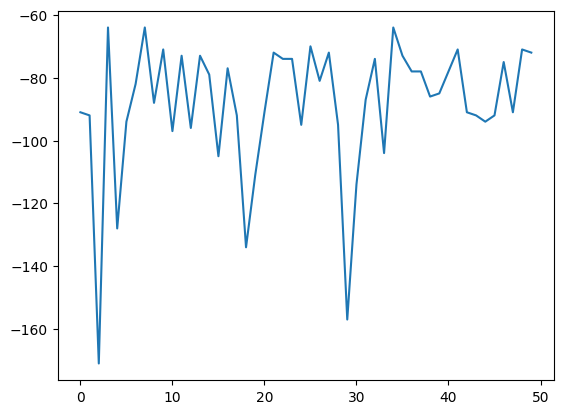


Recompensa de Media: -88.66 



In [110]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9


### Construcción de base de datos con 9 trayectoria

In [111]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [112]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

820


In [113]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [114]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 8.7560070e-01  4.8303560e-01  6.8907510e-02  9.9762300e-01
  -6.0182600e+00  8.0245590e+00]
 [ 7.3901190e-01 -6.7369240e-01 -9.5159600e-01  3.0735160e-01
  -6.2413980e+00  5.4462686e+00]
 [-3.0909360e-01 -9.5103160e-01 -7.8904770e-01 -6.1433190e-01
  -5.0800510e+00  4.5617430e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

### Separación de Train y Test

In [115]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [ 0.8756007   0.4830356   0.06890751 ...  0.          0.
   1.        ]
 [ 0.7390119  -0.6736924  -0.951596   ...  0.          0.
   1.        ]
 [-0.3090936  -0.9510316  -0.7890477  ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 656
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 164


In [116]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [117]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [118]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [119]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 1.8782957

g_loss= 3.8895636
 1/41 [..............................] - ETA: 6:08:04 - d_loss: 1.8783 - g_loss: 3.8896


d_loss= 2.0493019

g_loss= 3.633237
 2/41 [>.............................] - ETA: 5:35:55 - d_loss: 1.9638 - g_loss: 3.7614


d_loss= 1.969521

g_loss= 2.2734702
 3/41 [=>............................] - ETA: 5:26:21 - d_loss: 1.9657 - g_loss: 3.2654


d_loss= 1.8125798

g_loss= 1.0628328
 4/41 [=>............................] - ETA: 5:18:58 - d_loss: 1.9274 - g_loss: 2.7148


d_loss= 1.955257

g_loss= 0.80810744
 5/41 [==>...........................] - ETA: 5:13:23 - d_loss: 1.9330 - g_loss: 2.3334


d_loss= 1.8530645

g_loss= 3.955341
 6/41 [===>..........................] - ETA: 5:06:39 - d_loss: 1.9197 - g_loss: 2.6038


d_loss= 1.8854614

g_loss= 0.718399
 7/41 [====>.........................] - ETA: 4:58:28 - d_loss: 1.9148 - g_loss: 2.3344


d_loss= 2.0082445

g_loss= 1.1879967
 8/41 [====>.........................] - ETA: 4:49:54 - d_loss: 1.9265 - g_

### Evaluación de GAIL

In [120]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 1.8491e-04 - accuracy: 0.0000e+00
>Loss real: 
0.00019016952137462795
>Loss fake: 
0.00018490877118892968


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -72.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -76.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


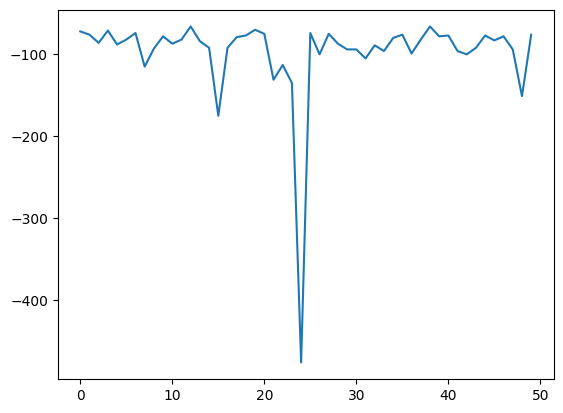


Recompensa de Media: -97.76 



In [121]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10


### Construcción de base de datos con 1 trayectoria

In [122]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [123]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

892


In [124]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [125]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

### Separación de Train y Test

In [126]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997995  -0.02002486  0.9999777  ...  0.          0.
   1.        ]
 [ 0.99992436 -0.01229871  0.99976075 ...  0.          0.
   1.        ]
 [ 0.99962884 -0.02724211  0.9951261  ...  0.          0.
   1.        ]
 ...
 [ 0.94503516  0.3269687  -0.39711353 ...  1.          0.
   0.        ]
 [ 0.3951314   0.91862464 -0.9999944  ...  1.          0.
   0.        ]
 [-0.22371536  0.9746545  -0.6253023  ...  1.          0.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 713
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 179


In [127]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [128]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [129]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [130]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 1.9035859

g_loss= 1.6379015
 1/45 [..............................] - ETA: 6:27:15 - d_loss: 1.9036 - g_loss: 1.6379


d_loss= 1.7929726

g_loss= 1.1886197
 2/45 [>.............................] - ETA: 6:09:32 - d_loss: 1.8483 - g_loss: 1.4133


d_loss= 1.9485815

g_loss= 1.012432
 3/45 [=>............................] - ETA: 6:12:01 - d_loss: 1.8817 - g_loss: 1.2797


d_loss= 1.8131837

g_loss= 0.8862399
 4/45 [=>............................] - ETA: 6:08:37 - d_loss: 1.8646 - g_loss: 1.1813


d_loss= 1.9291261

g_loss= 2.8319588
 5/45 [==>...........................] - ETA: 5:58:37 - d_loss: 1.8775 - g_loss: 1.5114


d_loss= 1.9214934

g_loss= 0.7181346
 6/45 [===>..........................] - ETA: 5:49:37 - d_loss: 1.8848 - g_loss: 1.3792


d_loss= 1.8920553

g_loss= 4.4847803
 7/45 [===>..........................] - ETA: 5:42:15 - d_loss: 1.8859 - g_loss: 1.8229


d_loss= 1.8976566

g_loss= 0.71546966
 8/45 [====>.........................] - ETA: 5:32:28 - d_loss: 1.8873 

### Evaluación de GAIL

In [131]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 3.9411e-05 - accuracy: 0.0000e+00
>Loss real: 
2.2782869564252906e-05
>Loss fake: 
3.941117392969318e-05


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  0 Total reward: -82.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
Episode  1 Total reward: -99.0
-1.0
-1.0
-1.0
-1.0
-1.0


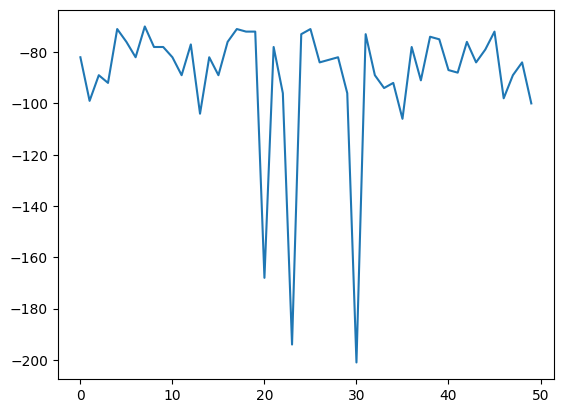


Recompensa de Media: -89.72 



In [132]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')